### Football match prediction
___

#### Summary

This notebook tries to predict the outcome of football matches using historical match data. The test season is the 2019/2020 English Premier League (the prior 10 seasons across the top 5 European leagues are used for training).

#### Index

1. [Preamble](#Preamble) <br>
2. [EDA](#EDA) <br>
3. [Feature Eng](#Feature-Eng)
4. [Model](#Model)
5. [Tuning](#Tuning)
6. [Predictions](#Predictions)
7. [Evaluate](#Evaluate)

#### Preamble
___

Library imports take place here (there are some scikit learn and keras functions that are imported under the hood in the modules - check the code of each module to see). Versions can be found in the requirements.txt. The project modules are all in the common folder and are broken down by functionality (general data functions, feature engineering and the model).

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import glob
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
import shap

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# modules
import common.data_methods as data_methods
import common.model as model
import common.feature_eng as feature_eng

To get the match result data go to [this site](https://www.football-data.co.uk/data.php). Here you will find multiple seasons of football data covering pretty much all the leagues in the world. The data mainly consists of match results, total shots and betting odds. Download the data and store in folder within the project, then point the function below to the file_path of the data (I have not included the raw data on the repo as its bad etiquette to do so!). Don't worry about subfolders within the data folder as the load_all_matches function searches all subfolders. 

In [3]:
# load all match data
all_matches = (
    data_methods.load_all_matches
    (r'C:\Users\frase\Documents\Analytics\football\result-predict\result-predict\data\matches')
)

#r'C:\Users\s0804424\OneDrive - University of Edinburgh\Documents-ENG-5216' \
    #r'\Analytics\football\result-predict\result-predict\data\matches'

#### EDA
___

Explore the data! Here I select columns that I am interested in and then check for duplicate matches. Also I look at correlations between features using a heatmap 

In [4]:
# select columns of interest
cols = ['Div','Date','HomeTeam','AwayTeam','FTR','FTR_le','H','D','A','FTHG','FTAG','HS','AS','HST','AST']
matches = all_matches[cols]

In [26]:
# check duplicate rows
len(matches[~matches.duplicated()])/len(matches)

1.0

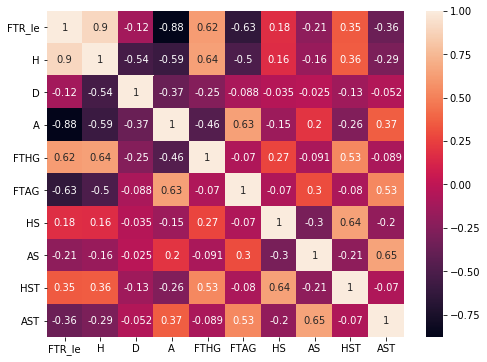

In [6]:
# heatmap for correlations
corr = matches.corr()
_=plt.figure(figsize=(8,6))
_=sns.heatmap(corr,annot=True)

#### Feature Eng
___

Using my domain knowledge of football, I create some features. Take a look at the feature_builder function in the feature_eng module for all the details. Remember the aim of the project is to predict the outcome of football matches. Therefore my features must contribute to this aim. I am particularly interested in home and away metrics (as teams generally perform better at home) and also I am interested in the form of the teams (how each team has been performing in the weeks prior to the present match).

These are the features that I create (I've listed the home ones, there are also the away equivalents):

- __HU__: count of home games unbeaten in the current season
- __HGD_rm__: goal difference at home, rolling mean
- __HST%_rm__: shots on target percentage at home, rolling mean
- __HSTC%_rm__: shots on target conceded percentage at home, rolling mean
- __HGS%_rm__: goals scored per shot at home, rolling mean
- __HGSC%_rm__: goals conceded per shot at home, rolling mean

In [18]:
# list of all teams in the dataset
teams = list(matches['HomeTeam'].unique())

In [27]:
# for each team compute features (with a user defined sliding window for the rolling mean) and store in a generator
team_df_gen = (feature_eng.feature_builder(i,matches,window=5) for i in teams)

In [28]:
# concat the generator
matches_df = pd.concat(team_df_gen)

In [30]:
# combining home and away into the same row (feature builder does home and away seperately)
comb_matches_df = feature_eng.combine_matches(matches_df,
                             fixed_feats=list(matches_df.columns)[:15])

In [31]:
# input and output columns of interest
y_cols = ['FTR','FTR_le','D', 'H', 'A']
x_cols = ['HU','HGD_rm','HST%_rm', 'HSTC%_rm', 'HGS%_rm', 'HGSC%_rm','AU',
          'AG_rm', 'AC_rm', 'AGD_rm', 'AST%','AST%_rm', 'ASTC%_rm', 'AGS%_rm', 'AGSC%_rm']

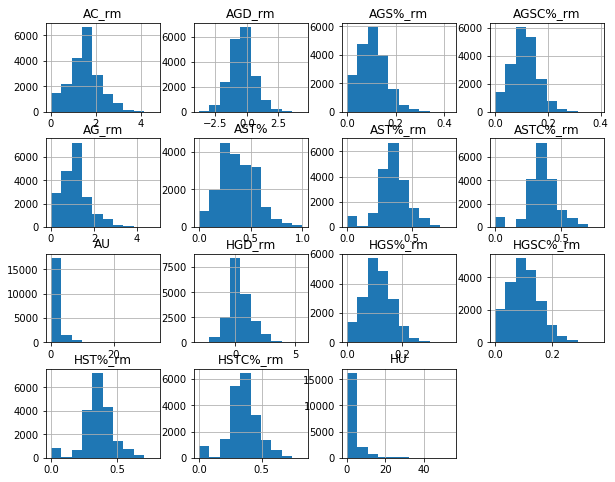

In [32]:
_=comb_matches_df[x_cols].hist(figsize=(10,8))

#### Model
___

A deep neural network is built using the Keras sequential class. The NeuralNet class can be found in the model module and contains methods to build a model, do grid search cross validation, fit a model and make predictions of classes and probabilities. 

In [33]:
# training/testing data
train_x = data_methods.train_test_split(comb_matches_df,x_cols,y_cols,StandardScaler())['train_x']
train_y = data_methods.train_test_split(comb_matches_df,x_cols,y_cols,StandardScaler())['train_y']

test_x = data_methods.train_test_split(comb_matches_df,x_cols,y_cols,StandardScaler())['test_x']
test_y = data_methods.train_test_split(comb_matches_df,x_cols,y_cols,StandardScaler())['test_y']

In [34]:
# create a neural net object
nn = model.NeuralNet(train_x,train_y,test_x,test_y,input_dim=train_x.shape[1],output_dim=3)

#### Tuning
___

Tuning the model involves finding the optimum hyperparameters that give the highest model accuracy. Scikit learns Grid search cross validation method is used 

In [35]:
parameters = {'batch_size':[32],
             'nb_epoch':[100],
              'hn1':[32],
             'hn2':[18],
             'hn3':[9,10]}

In [36]:
gridsearch = nn.gridCV(parameters=parameters)

In [37]:
gridsearch.cv_results_['mean_test_score']

array([0.52766103, 0.53133019])

In [38]:
gridsearch.best_score_

0.5313301925010128

In [39]:
gridsearch.best_params_

{'batch_size': 32, 'hn1': 32, 'hn2': 18, 'hn3': 10, 'nb_epoch': 100}

#### Predictions
___

Fit the final model using the best parameters from the grid search. Then make predictions using the 2019/20 EPL data and print the classification report

In [40]:
final_classifier = nn.build_classifier(
                                       hn1 = gridsearch.best_params_['hn1'],
                                       hn2 = gridsearch.best_params_['hn2'],
                                       hn3 = gridsearch.best_params_['hn3'])

In [41]:
fitted_classifier = nn.fit_classifier(epochs = gridsearch.best_params_['nb_epoch'],
                                         batch_size = gridsearch.best_params_['batch_size'],
                                          compiled_model = final_classifier)

In [42]:
nn.predictions(fitted_classifier)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,FTR_le,D,H,A,PClass,PA,PD,PH
0,2019-08-17,Aston Villa,Bournemouth,1.0,2.0,A,0,0,0,1,0,0.621247,0.273079,0.105674
1,2019-08-23,Aston Villa,Everton,2.0,0.0,H,2,0,1,0,2,0.049109,0.395463,0.555428
2,2019-09-16,Aston Villa,West Ham,0.0,0.0,D,1,1,0,0,2,0.077234,0.433231,0.489535
3,2019-09-28,Aston Villa,Burnley,2.0,2.0,D,1,1,0,0,2,0.139145,0.347829,0.513026
4,2019-10-19,Aston Villa,Brighton,2.0,1.0,H,2,0,1,0,2,0.081229,0.439666,0.479105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2020-02-29,Brighton,Crystal Palace,0.0,1.0,A,0,0,0,1,2,0.130562,0.333126,0.536312
284,2019-12-16,Crystal Palace,Brighton,1.0,1.0,D,1,1,0,0,0,0.519396,0.201311,0.279293
285,2020-02-22,Sheffield United,Brighton,1.0,1.0,D,1,1,0,0,2,0.207045,0.299126,0.493829
286,2020-02-01,Crystal Palace,Sheffield United,0.0,1.0,A,0,0,0,1,2,0.323193,0.305450,0.371357


In [43]:
print(classification_report(y_true=nn.predictions(fitted_classifier)['FTR_le'],
                            y_pred =nn.predictions(fitted_classifier)['PClass'],
                            target_names=['A','D','H']))

              precision    recall  f1-score   support

           A       0.55      0.60      0.57        87
           D       0.31      0.14      0.19        72
           H       0.55      0.69      0.61       129

    accuracy                           0.52       288
   macro avg       0.47      0.48      0.46       288
weighted avg       0.49      0.52      0.50       288



#### Evaluate
___

To interprete the outputs of the model, Shapley values are used. They originate in game theory and show the marginal contribution of a feature to the overall predictive capability of the model. Plotting the Shapley values allows for the relative importance of the features to be seen visually - actions can therefore be taken based on this.

In [44]:
# shap library
explainer = shap.DeepExplainer(fitted_classifier,test_x)
shap_values = explainer.shap_values(test_x)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


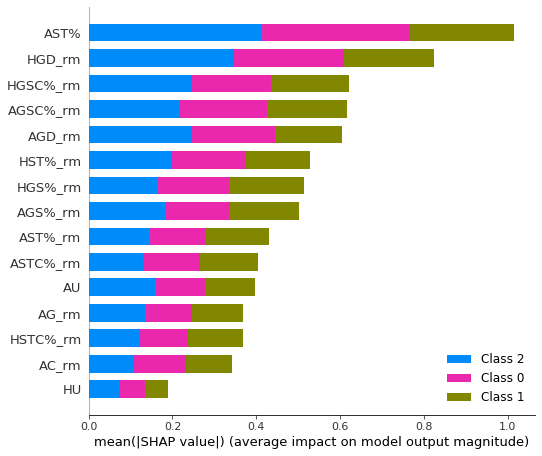

In [45]:
# dataframe testx 
test_x_df = pd.DataFrame(test_x,columns=x_cols)
_=shap.summary_plot(shap_values, test_x_df, plot_type="bar")

#### Beat the bookies?
___

In [62]:
odds = all_matches[['Date','HomeTeam','AwayTeam','FTR','B365D','B365H','B365A','WHD','WHH','WHA']]